
## Семинар 4. Модели экспоненциального сглаживания. Порядок построения и валидации модели.



In [35]:
from sktime.datasets import load_uschange
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np


from sktime.forecasting.all import temporal_train_test_split
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

from sktime.forecasting.base import ForecastingHorizon

from sktime.datasets import load_macroeconomic, load_airline

from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV

from sktime.utils.plotting import plot_correlations


plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,5)


### Модели Хольта-Винтерса и ETS

Для начала возьмём какие-нибудь простые данные без трендов. В нашем случае это будет один из стандартных датасетов. Используем процентные изменения в совокупном потреблении США c 1960 по 2006.

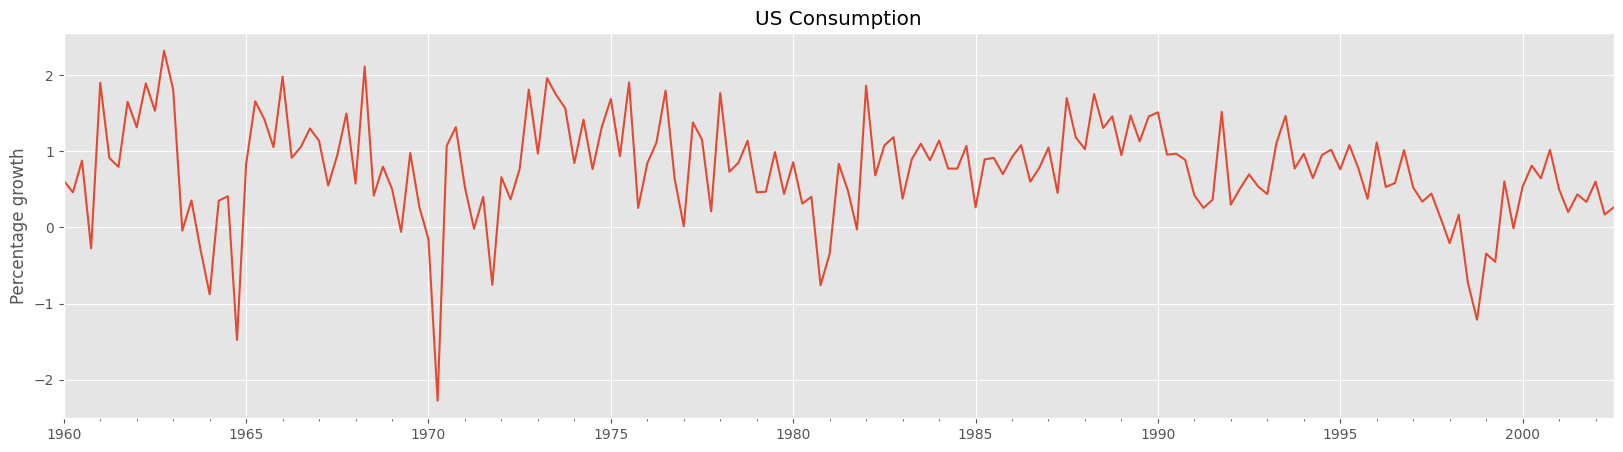

In [36]:
y, _ = load_uschange()
y.index = pd.date_range(start="1960.01.01", periods=len(y), freq="Q").to_period()

# Если потребуются мультипликативные модели, необходимо децентрировать данные
# y = y + 10

test_size = 16

horizon = ForecastingHorizon(list(range(1, test_size+1)))
y_train, y_test = temporal_train_test_split(y, test_size=test_size)

y_train.plot()
plt.title("US Consumption")
plt.ylabel("Percentage growth");

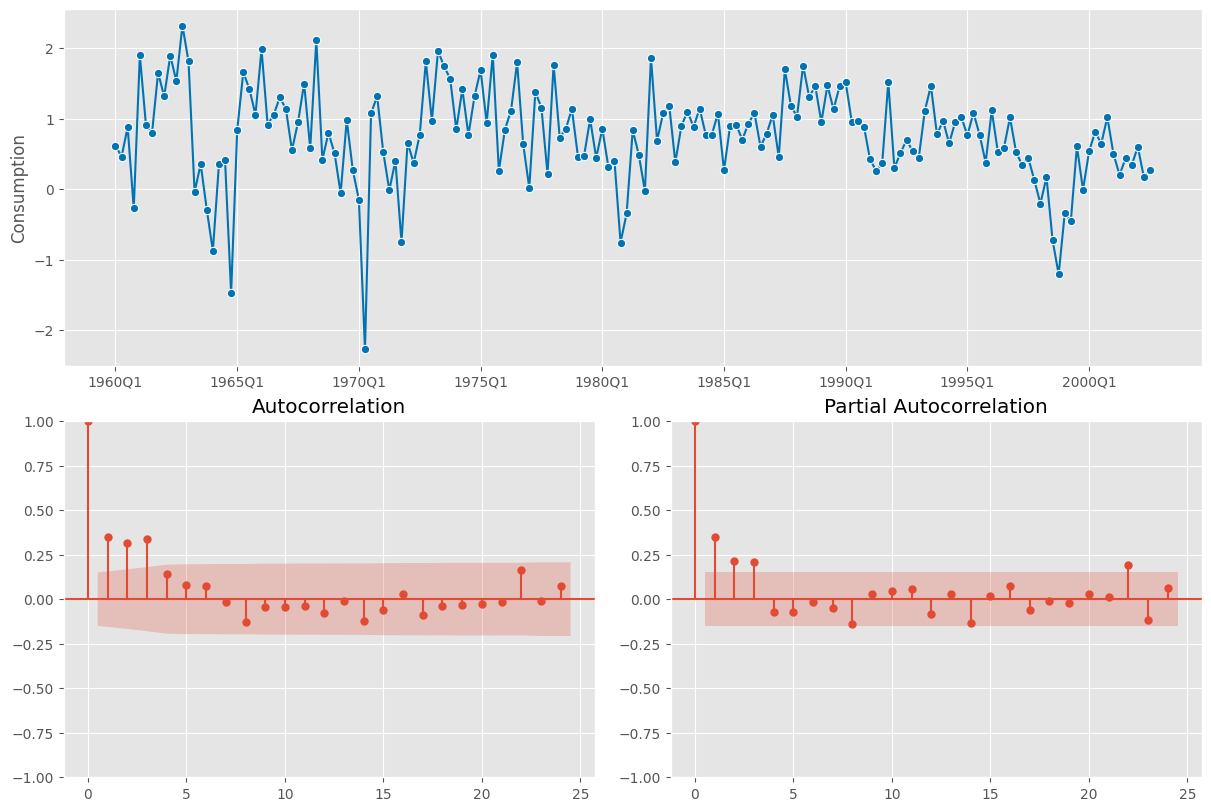

In [39]:
plot_correlations(y_train);

Импортируем модели Хольта-Винтерса и ETS. Из последнего семинара мы знаем, что эти модели в целом различаются только метедом оценки, но структурно эквивалентны. Посмотрим на простом примере, а далее будем использовать только ETS, чтобы не дублировать слишком много кода.

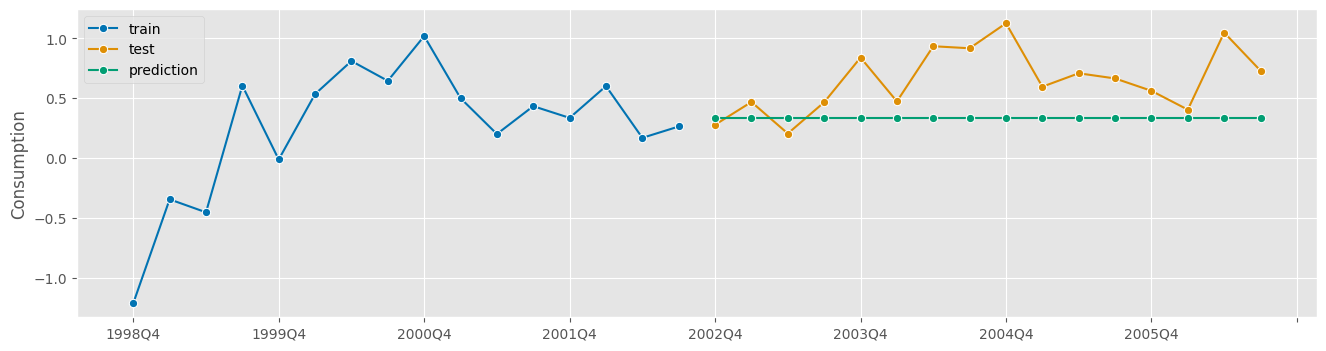

In [41]:
forecaster = ExponentialSmoothing()
forecaster.fit(y_train)

y_pred = forecaster.predict(fh=horizon)

plot_series(y_train.tail(test_size), y_test, y_pred,  labels=['train', 'test', 'prediction']);



In [42]:
mean_absolute_percentage_error(y_test, y_pred)

0.4673049327896513

In [43]:
forecaster._fitted_forecaster.params

{'smoothing_level': 0.3284051849863883,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 0.6907156679366819,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

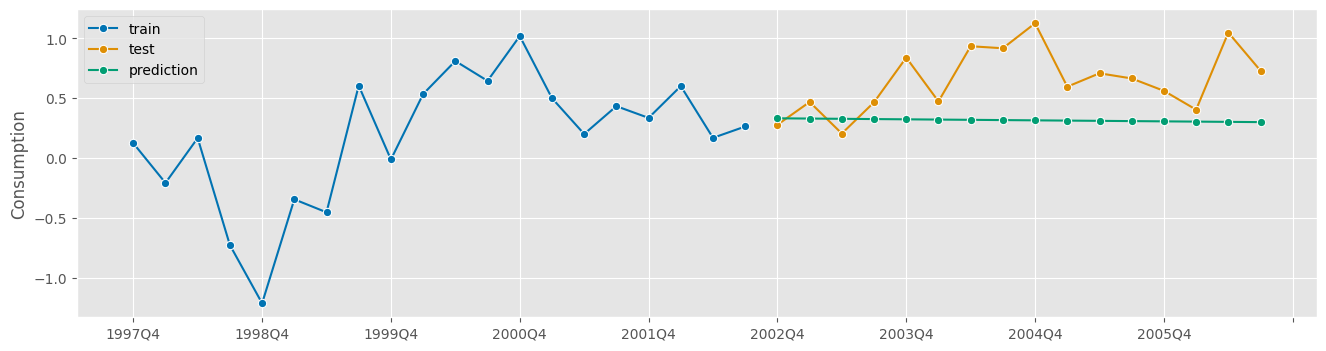

In [44]:
forecaster = ExponentialSmoothing(trend="add")
forecaster.fit(y_train)

y_pred = forecaster.predict(fh=horizon)

plot_series(y_train.tail(20), y_test, y_pred,  labels=['train', 'test', 'prediction']);


In [45]:
mean_absolute_percentage_error(y_test, y_pred)

0.4949503337428813

Как видим ниже, оценён параметр $l_0$. Вообще параметр $\alpha$ тоже под капотом оценился, но почему-то не пробросился.

Внимательный читатель спросит, мол, как это оценены информационные критерии, у нас же эти модели оцениваются не через правдоподобие. В таком случае можно записать информационные критерии через MSE, а не через правдоподобие. Более того, вариантов записи информационных критериев существует немало, поэтому рекомендуется всегда поглядывать в документацию или потроха пакета.

In [46]:
forecaster._fitted_forecaster.params

{'smoothing_level': 0.32799568235607074,
 'smoothing_trend': 0.0,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 0.697306382142234,
 'initial_trend': -0.0021212263075610616,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [14]:
forecaster._fitted_forecaster.aic

-143.88709148148564

In [47]:
forecaster.predict_interval()

NotImplementedError: ExponentialSmoothing does not have the capability to return prediction intervals. If you think this estimator should have the capability, please open an issue on sktime.

Теперь оценим ETS(A,N,N)-модель. Как видим, легко получается то же самое.

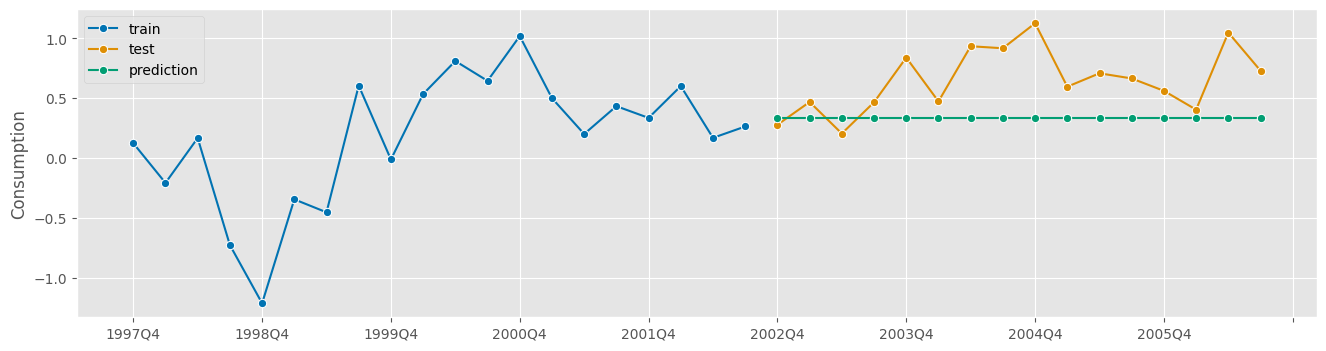

In [48]:
forecaster = AutoETS()
forecaster.fit(y_train)

y_pred = forecaster.predict(fh=horizon)

plot_series(y_train.tail(20), y_test, y_pred,  labels=['train', 'test', 'prediction']);
print(f'Forecast error: {mean_absolute_percentage_error(y_test, y_pred)}')


Однако выдача ETS-модели куда приятнее. Видим, что оценки $l_o$ и $\alpha$ совпали с предыдущим случаем.

In [49]:
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:            Consumption   No. Observations:                  171
Model:                       ETS(ANN)   Log Likelihood                -166.703
Date:                Tue, 06 Feb 2024   AIC                            339.407
Time:                        19:33:20   BIC                            348.832
Sample:                    03-31-1960   HQIC                           343.231
                         - 09-30-2002   Scale                            0.411
Covariance Type:               approx                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.3284      0.070      4.685      0.000       0.191       0.466
initial_level       0.6904      0.478      1.444      0.149      -0.247       1.628
===================================================================================
Ljung-Box (Q):                        0.05   Jarque-Bera (JB):                18.67
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

Теперь возьмём какие-нибудь трендированные данные.

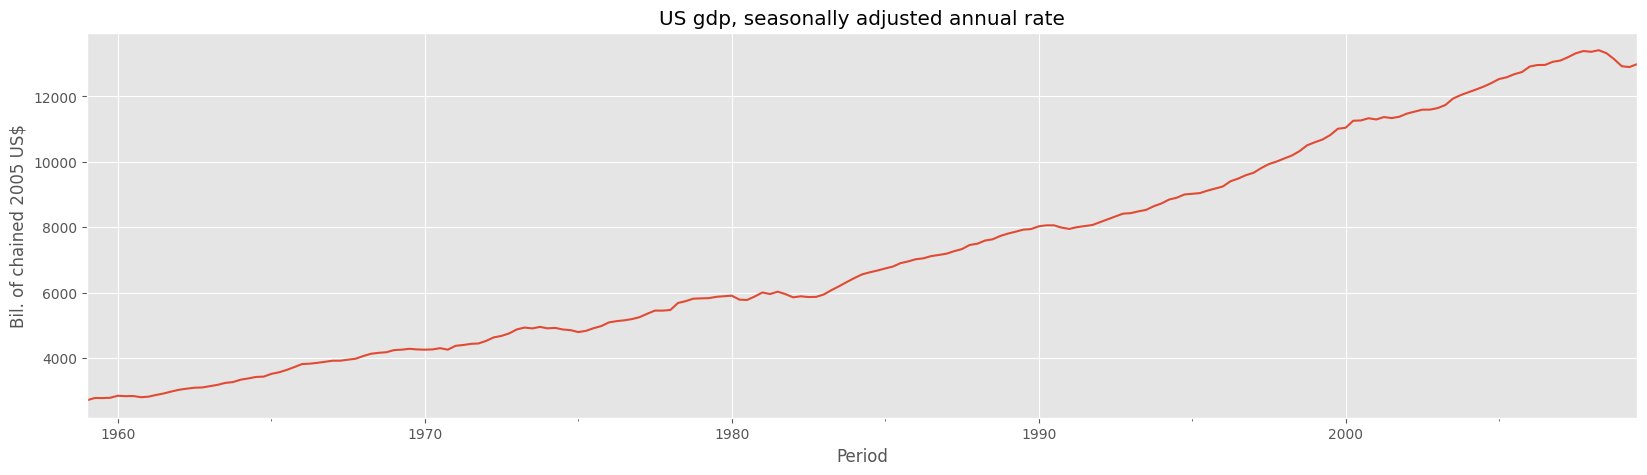

In [50]:
y = load_macroeconomic().realgdp
y.plot()
plt.title('US gdp, seasonally adjusted annual rate')
plt.ylabel('Bil. of chained 2005 US$')

horizon = 35
y_train, y_test = temporal_train_test_split(y, test_size=horizon)

horizon = ForecastingHorizon(list(range(1, horizon+1)))

Text(0, 0.5, 'Bil. of chained 2005 US$')

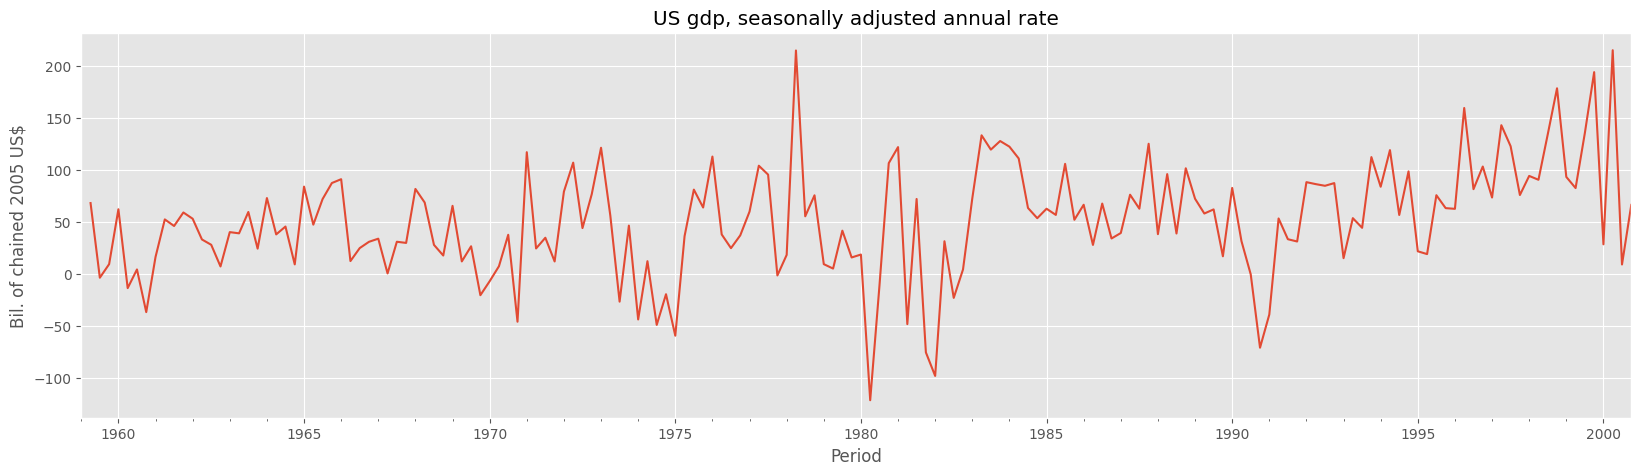

In [51]:
y_train.diff().plot()
plt.title('US gdp, seasonally adjusted annual rate')
plt.ylabel('Bil. of chained 2005 US$')

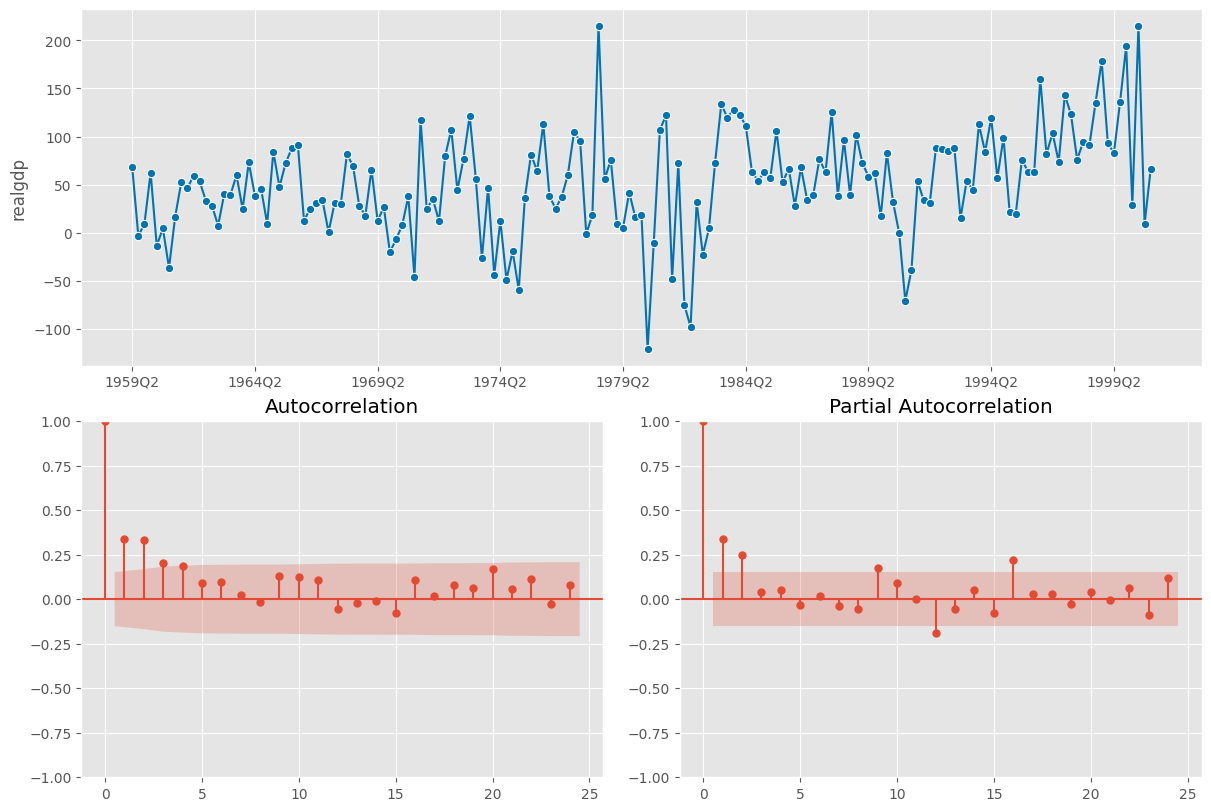

In [52]:
plot_correlations(y_train.diff().dropna());

Понятное дело, что здесь уже необходимо применять модель, в которой есть трендовая компонента. Попробуем применить.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                realgdp   No. Observations:                  168
Model:                       ETS(AAN)   Log Likelihood                -896.624
Date:                Tue, 06 Feb 2024   AIC                           1803.249
Time:                        19:34:24   BIC                           1818.869
Sample:                    03-31-1959   HQIC                          1809.588
                         - 12-31-2000   Scale                         2530.629
Covariance Type:               approx                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.9999      0.119      8.430      0.000       0.767       1.232
smoothing_trend     0.1887      0.177      1.065      0.287      -0.158       0.536
initial_level    2683.8456     51.073     52.549      0.000    2583.743    2783.948
initial_trend      23.2481     31.164      0.746      0.456     -37.831      84.328
===================================================================================
Ljung-Box (Q):                        3.39   Jarque-Bera (JB):                 3.86
Prob(Q):                              0.18   Prob(JB):                         0.15
Heteroskedasticity (H):               1.97   Skew:                            -0.01
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

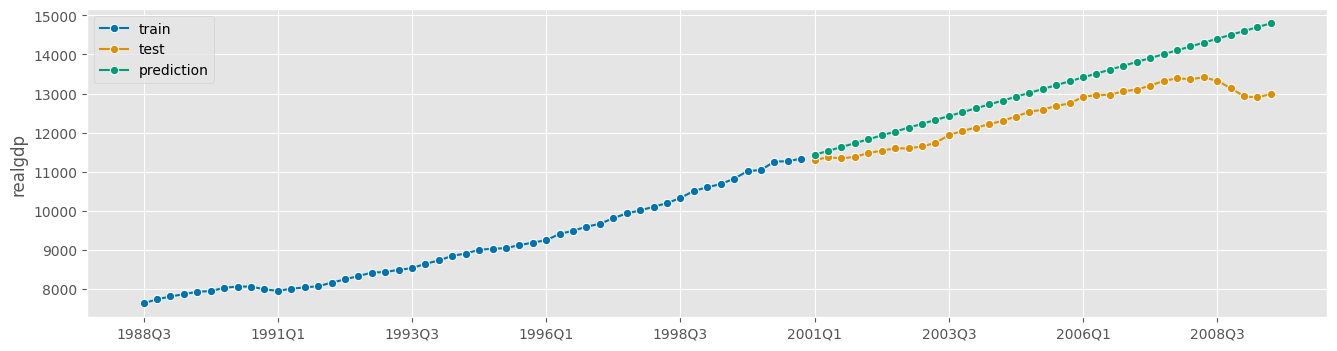

In [53]:
forecaster = AutoETS(trend="add")
forecaster.fit(y_train)

y_pred = forecaster.predict(fh=horizon)

plot_series(y_train.tail(50), y_test, y_pred,  labels=['train', 'test', 'prediction']);
forecaster.summary()

In [54]:
mean_absolute_percentage_error(y_test, y_pred)

0.05303641295835393

Видим явную переоценку тренда. Попробуем дампировать

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                realgdp   No. Observations:                  168
Model:                      ETS(AAdN)   Log Likelihood                -896.982
Date:                Tue, 06 Feb 2024   AIC                           1805.964
Time:                        19:35:09   BIC                           1824.708
Sample:                    03-31-1959   HQIC                          1813.571
                         - 12-31-2000   Scale                         2541.424
Covariance Type:               approx                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.9999      0.284      3.526      0.000       0.444       1.556
smoothing_trend     0.2511      0.431      0.582      0.560      -0.594       1.096
damping_trend       0.9800      0.101      9.669      0.000       0.781       1.179
initial_level    2739.0843     53.152     51.533      0.000    2634.909    2843.260
initial_trend      12.2548     40.696      0.301      0.763     -67.509      92.018
===================================================================================
Ljung-Box (Q):                        0.90   Jarque-Bera (JB):                 3.80
Prob(Q):                              0.64   Prob(JB):                         0.15
Heteroskedasticity (H):               1.89   Skew:                             0.04
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

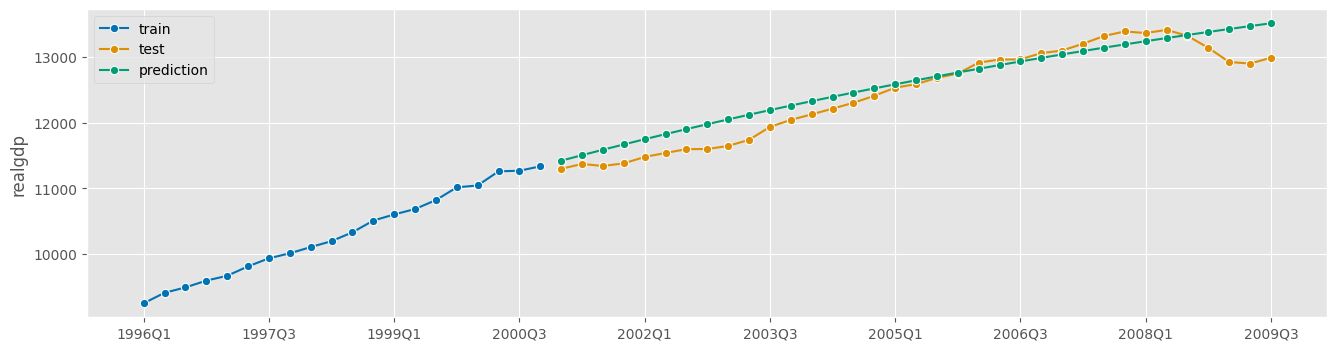

In [55]:
forecaster = AutoETS(trend="add", damped_trend=True)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh=horizon)

plot_series(y_train.tail(20), y_test, y_pred,  labels=['train', 'test', 'prediction']);
forecaster.summary()

In [34]:
mean_absolute_percentage_error(y_test, y_pred)

0.016382730954727802

Мультипликативный тренд, по понятным причинам, ничего особо не изменит, так как тренд затухающий, а не экспоненциальный. Да и дамприование с мультипликативным трендом выглядит несколько противоестественно.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                realgdp   No. Observations:                  168
Model:                      ETS(AMdN)   Log Likelihood                -897.171
Date:                Mon, 13 Feb 2023   AIC                           1806.341
Time:                        20:29:02   BIC                           1825.085
Sample:                    03-31-1959   HQIC                          1813.948
                         - 12-31-2000   Scale                         2547.136
Covariance Type:               approx                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.9999      0.174      5.762      0.000       0.660       1.340
smoothing_trend     0.2507      0.253      0.992      0.321      -0.244       0.746
damping_trend       0.9697      0.060     16.185      0.000       0.852       1.087
initial_level    2739.0854     53.354     51.338      0.000    2634.514    2843.656
initial_trend       1.0048      0.015     68.813      0.000       0.976       1.033
===================================================================================
Ljung-Box (Q):                        0.86   Jarque-Bera (JB):                 3.71
Prob(Q):                              0.65   Prob(JB):                         0.16
Heteroskedasticity (H):               1.89   Skew:                             0.05
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

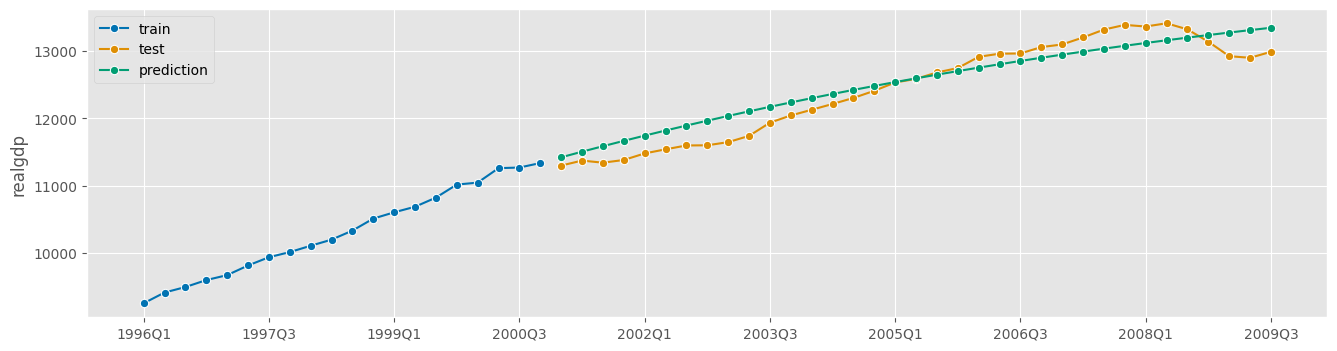

In [133]:
forecaster = AutoETS(trend="mul", damped_trend=True)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh=list(range(1,len(y_test)+1)))

plot_series(y_train.tail(20), y_test, y_pred,  labels=['train', 'test', 'prediction']);
forecaster.summary()



In [134]:
mean_absolute_percentage_error(y_test, y_pred)

0.01660804975211629